# Creating the f1rate dataset in another format

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
sys.path.append('../')

from src import load_data

## Loading root file and preprocessing the data

- We load the root file using uproot and show its contents. We can then obtain a dictionary where keys are some of the TTree names and values are numpy arrays containing the data. **Note that we might only keep a subset of the information**.

In [3]:
data_dict = load_data.load_data_as_dict(root_filename = "../data/fmrate.root",
                                        TTree_features_dict={
                        "fmrate":
                                ["time_since_saa", # saa 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               # "obox_mode",
                               "temperature",  # sum
                               "glon", 
                               "glat",
                               "unix_time",  # tunix
                               "fe_cosmic",  # sum
                               "rate",  # fe_rate 12 instead of 25 because energies instead of modules
                               "config",  # new, interested in config=42
                               "is_orbit_up", # new
                               "altitude",
                               "sun",
                               "sun_spot",
                               "B_r",
                               "B_theta",
                               "B_phi"
                               # "crabarf"  # new, bright light, TODO: to better understand
                                # need magnetic field info too.
                                ]})

TTree: fmrate's contents:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
unix_time            | double                   | AsDtype('>f8')
rate                 | double[12]               | AsDtype("('>f8', (12,))")
glat                 | double                   | AsDtype('>f8')
glon                 | double                   | AsDtype('>f8')
altitude             | double                   | AsDtype('>f8')
temperature          | float                    | AsDtype('>f4')
fe_cosmic            | float                    | AsDtype('>f4')
corrected            | double[1]                | AsDtype("('>f8', (1,))")
correrr              | double[1]                | AsDtype("('>f8', (1,))")
config               | int32_t                  | AsDtype('>i4')
raz                  | double                   | AsDtype('>f8')
decz                 | double                   | AsDtype('>f8')
r

<!--The TTree `B_field` contains information on the magnetic field and is aligned with the data in `t_hk_obox`--->

In [4]:
data_dict.keys()

dict_keys(['time_since_saa', 'raz', 'decz', 'rax', 'decx', 'temperature', 'glon', 'glat', 'unix_time', 'fe_cosmic', 'rate', 'config', 'is_orbit_up', 'altitude', 'sun', 'sun_spot', 'B_r', 'B_theta', 'B_phi'])

- Create a pandas dataframe containing all the features we selected where we keep only one of the `rate` (e.g first one. We don't have anymore $25$ modules). We no longer have $25$ values for the temperature and `fe_cosmic`.

In [5]:
i = 0  # rate[i]
data_df = pd.DataFrame.from_dict(dict((k, v) if k != "rate" else (f"rate[{i}]", v[:, i]) for k, v in data_dict.items()))
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,rate[0],config,is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,56941.760321,42,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,58123.694878,42,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,58244.963030,42,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,58325.603325,42,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,57655.444528,42,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,166768.282730,42,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,201208.113638,42,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,168499.665785,42,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,157398.392828,42,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


In [6]:
data_df.dtypes

time_since_saa    float64
raz               float64
decz              float64
rax               float64
decx              float64
temperature       float32
glon              float64
glat              float64
unix_time         float64
fe_cosmic         float32
rate[0]           float64
config              int32
is_orbit_up          bool
altitude          float64
sun               float64
sun_spot          float64
B_r               float64
B_theta           float64
B_phi             float64
dtype: object

Let's quickly check if `config` = `42` for all of them

In [7]:
assert np.all(data_df["config"] == 42), "there is at least one config != 42"

In [8]:
# Drop the column config
data_df.drop(columns=["config"], inplace=True)
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,rate[0],is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,56941.760321,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,58123.694878,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,58244.963030,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,58325.603325,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,57655.444528,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,166768.282730,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,201208.113638,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,168499.665785,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,157398.392828,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


In [9]:
tunix_name, target_name = 'unix_time', f'rate[{i}]'

**Need for normalizing some features ? Probably, we'll do it later and after splitting the data (otherwise data leakage)!!**

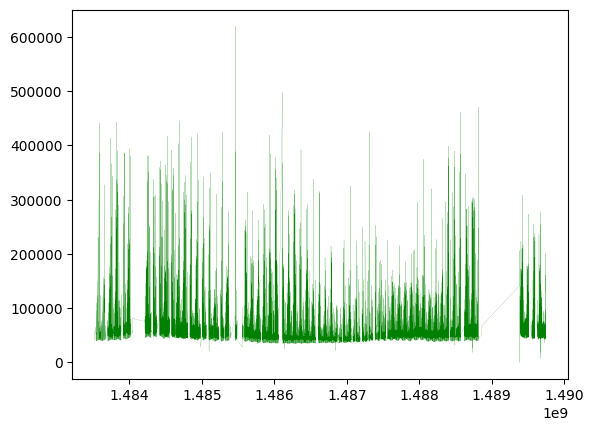

In [10]:
plt.plot(data_df[tunix_name], data_df[target_name], 'g', linewidth=0.1)
plt.show()

In [11]:
data_df[tunix_name][:10]-data_df[tunix_name][:10].min()

0      0.000000
1     60.000315
2    120.000456
3    180.001091
4    240.001360
5    300.002035
6    360.002039
7    420.002283
8    480.002432
9    540.002536
Name: unix_time, dtype: float64

This time, **we don't have $2$ seconds between examples but 1 minute** ! (`fmrate`; `m` for minute). We'll see that it's sometimes not true because we **might have missing data**.

In [12]:
sample_spacing = 60  # 60 seconds

- Filter out the data and bin the data

We first remove a part of missing data on the right (if exists)

In [13]:
last_non_zero = data_df.shape[0]-(np.flip(data_df[target_name])>0).argmax() - 1

In [14]:
data_df = data_df.iloc[:last_non_zero+1, :]
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,rate[0],is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,56941.760321,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,58123.694878,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,58244.963030,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,58325.603325,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,57655.444528,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,166768.282730,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,201208.113638,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,168499.665785,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,157398.392828,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


Then we "bin" the data (like profile hist but without error bars and without plotting)

In [15]:
tunix_min = data_df[tunix_name].min()
tunix_shifted = data_df[tunix_name] - tunix_min
bins = np.arange(0, tunix_shifted.max()+sample_spacing, sample_spacing)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)

# Quantized Shifted Time
t = bins[indices_digitized]

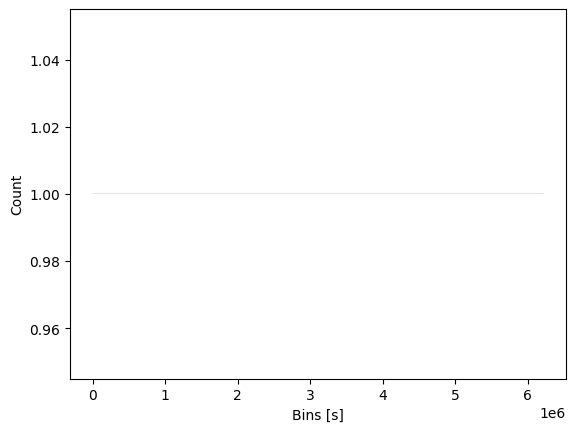

In [16]:
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

This above shows there's no need to average data falling into bins because there's is maximum one there.

In [17]:
np.unique(bins[uniques_idx]).size, bins.size

(64682, 103655)

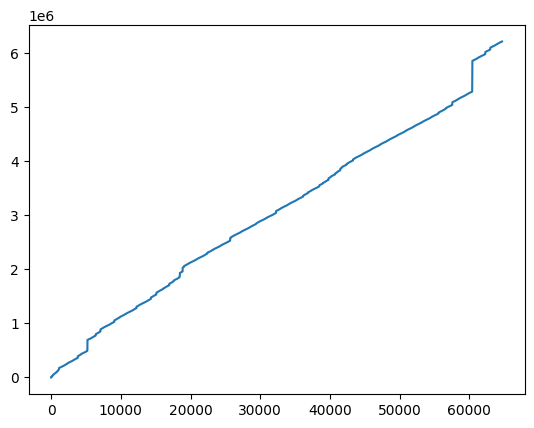

In [18]:
plt.plot(np.unique(bins[uniques_idx]))

However, there are **empty bins** !!

In [19]:
data_df.describe()

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,rate[0],altitude,sun,sun_spot,B_r,B_theta,B_phi
count,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,6.468200e+04,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000
mean,4362.710796,179.909775,9.933683,187.390251,27.468865,32.368153,4.528730,4.205896,1.486576e+09,6379.344238,60662.933355,379.761023,19.416762,76.886800,-1744.641725,-22471.115984,450.366511
std,7048.901460,105.377543,29.171879,114.178519,37.821989,2.979160,109.655682,28.744569,1.648714e+06,4497.713867,33853.945687,4.814710,15.230018,4.286684,27042.615707,5209.759844,4176.203522
min,0.000000,0.001536,-51.780590,0.002334,-86.673214,15.600000,-179.991849,-42.765346,1.483525e+09,0.000000,0.000000,369.374436,1.000000,69.600000,-42462.292221,-34348.277689,-10451.631738
25%,680.072750,87.719069,-16.505383,75.428649,32.920924,30.000000,-100.546931,-22.321477,1.485178e+09,3307.000000,43936.237108,375.989172,8.000000,73.400000,-27641.450574,-25876.891644,-2398.326249
50%,2012.169750,180.417892,12.371567,220.409236,39.118393,32.299999,20.630334,7.448405,1.486611e+09,4554.500000,49735.378527,380.147860,15.000000,76.200000,-4540.288052,-22416.335283,594.087284
75%,4014.362250,271.839385,35.993074,283.994691,49.555842,34.299999,101.321960,31.533336,1.487928e+09,7488.000000,63401.755106,383.494752,26.000000,80.000000,21586.758252,-19231.722319,3951.773996
max,65271.428000,359.993599,53.794792,359.998220,86.635762,39.000000,179.998087,42.764834,1.489745e+09,25630.000000,619182.232039,391.016348,97.000000,86.800000,50736.932600,-8915.841049,8130.351550


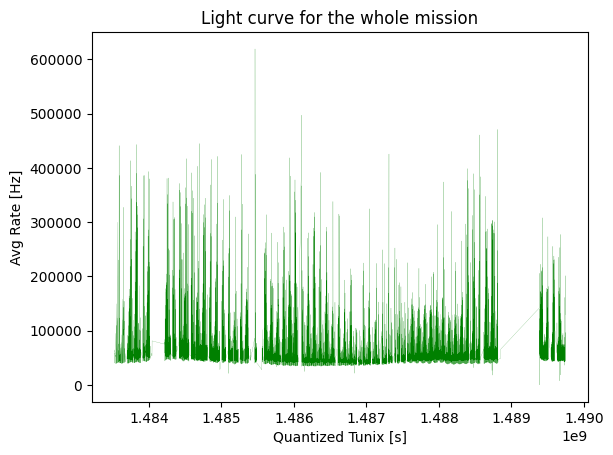

In [20]:
plt.plot(data_df[tunix_name], data_df[target_name], 'g', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

Up to this point, our data is **not** at equidistant quantized times due to missing values/data

In [21]:
# Uncomment below if want to export the data into a CSV file
# import os  

# os.makedirs('../data', exist_ok=True)
# data_df.to_csv('../data/fmrate_dataset_binned.csv', index=False)  

In [22]:
import os  

os.makedirs('../data', exist_ok=True)
data_df.to_csv('../data/fmrate_dataset.csv', index=False)  

In [23]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,rate[0],is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,56941.760321,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,58123.694878,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,58244.963030,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,58325.603325,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,57655.444528,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,166768.282730,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,201208.113638,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,168499.665785,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,157398.392828,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


In [24]:
corr = data_df.corr()

In [25]:
corr

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,rate[0],is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
time_since_saa,1.000000,-0.016123,-0.014943,-0.021574,-0.056437,-0.035310,-0.025629,-0.002408,0.129891,-0.123445,-0.112667,-0.120509,0.021296,0.035497,-0.088340,0.000143,-0.125707,0.105886
raz,-0.016123,1.000000,0.040565,-0.175890,0.267840,-0.391651,-0.029270,-0.017659,-0.022333,0.017391,0.081664,0.030462,0.495872,-0.005989,0.062445,0.010233,0.018171,0.018280
decz,-0.014943,0.040565,1.000000,-0.174004,0.022612,0.038125,-0.021730,0.966202,0.030380,-0.201017,-0.206622,0.090193,-0.484203,-0.032697,0.000779,-0.933528,-0.310814,-0.107196
rax,-0.021574,-0.175890,-0.174004,1.000000,0.239807,0.499479,0.017784,-0.230294,0.138497,-0.001894,-0.078112,0.066907,-0.161187,0.030909,-0.214959,0.231737,0.028350,0.030395
decx,-0.056437,0.267840,0.022612,0.239807,1.000000,0.030740,0.015357,-0.207660,0.162230,0.056662,0.019531,0.400135,0.313608,-0.126796,0.002686,0.201927,0.087633,0.032298
temperature,-0.035310,-0.391651,0.038125,0.499479,0.030740,1.000000,-0.003427,0.018672,0.104274,-0.004938,-0.212160,-0.006556,-0.474675,0.035500,-0.193778,-0.016236,0.001973,-0.003891
glon,-0.025629,-0.029270,-0.021730,0.017784,0.015357,-0.003427,1.000000,-0.023536,-0.005938,0.050261,0.015259,0.023350,0.008094,0.004083,0.003485,0.158558,-0.212829,-0.352334
glat,-0.002408,-0.017659,0.966202,-0.230294,-0.207660,0.018672,-0.023536,1.000000,-0.010727,-0.224897,-0.217072,-0.002064,-0.539775,0.000147,0.002187,-0.964626,-0.339317,-0.112212
unix_time,0.129891,-0.022333,0.030380,0.138497,0.162230,0.104274,-0.005938,-0.010727,1.000000,0.012757,-0.028899,0.016509,0.043884,0.017814,-0.058984,0.015806,-0.007417,0.018213
fe_cosmic,-0.123445,0.017391,-0.201017,-0.001894,0.056662,-0.004938,0.050261,-0.224897,0.012757,1.000000,0.724257,-0.004068,0.060418,-0.009257,-0.016584,0.221685,0.750556,-0.195923


Text(0.5, 1.0, 'Correlation Matrix between types of measurements')

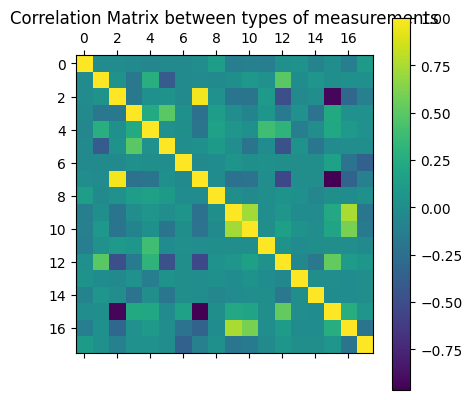

In [26]:
plt.matshow(corr)
plt.colorbar()

plt.title('Correlation Matrix between types of measurements')

In [28]:
corr[target_name]

time_since_saa   -0.112667
raz               0.081664
decz             -0.206622
rax              -0.078112
decx              0.019531
temperature      -0.212160
glon              0.015259
glat             -0.217072
unix_time        -0.028899
fe_cosmic         0.724257
rate[0]           1.000000
is_orbit_up       0.010409
altitude          0.153309
sun               0.038158
sun_spot          0.000001
B_r               0.184330
B_theta           0.594078
B_phi            -0.159937
Name: rate[0], dtype: float64